In [1]:
# import
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from PIL import Image
import shutil

# costants
SEED = 0xDED
KAGGLE = os.path.exists("/kaggle/input")
if KAGGLE:
    print("Detected kaggle environment")

target_w = 512
target_h = 512

batch_size = 1
num_classes = 3    
epochs = 1

learning_rate = 1e-4

use_crop = True

In [2]:
# intialization and common utilities

tf.random.set_seed(SEED)
np.random.seed(SEED)

def fromCwd(path):
    return os.path.join(os.getcwd(), path)


if KAGGLE:
    train_dir = "/kaggle/temp/training"
    valid_dir = "/kaggle/temp/validation"
    data_dir = "/kaggle/input/Development_Dataset/Training"
    temp_dir = "/kaggle/temp/mvdir"
    checkpoint_dir = "/kaggle/temp/checkpoints"
    test_dir = "/kaggle/input/Development_Dataset/Test_Dev"
    output_dir = fromCwd("/kaggle/working")
else:
    train_dir = fromCwd("training")
    valid_dir = fromCwd("validation")
    data_dir = fromCwd("data")
    temp_dir = fromCwd("temp")
    checkpoint_dir = fromCwd("checkpoints")
    test_dir = fromCwd("test")
    output_dir = fromCwd("output")



In [3]:
# crop image

# make crops and return the sub images
def cropImg(image, target_w, target_h):
    w, h = image.size
    div_x = int(w/target_w)
    div_y = int(w/target_h)
    if div_x <= 0:
        div_x = 1
    if div_y <= 0:   
        div_y = 1
    

    w /= div_x
    h /= div_y

    sub_images = []
    # x and y are swapped to have array "rows" match image rows
    for y in range(div_y):
        for x in range(div_y):
            sz = (x*w, y*h, x*w + w, y*h + h)
            sub_images.append(image.crop(sz))

    return sub_images

#save images to disk
def saveImagesArray(images, original_name, dest_dir):
    filename, file_extension = os.path.splitext(original_name)
    for i in range(len(images)):
        img = images[i]
        w, h = img.size
        img.save(os.path.join(dest_dir, filename + "_cp" + str(i) + "_" + str(w) + "x" + str(h) + file_extension))

# recursively crop all images into a directory maitaining the same
# internal structure to the destination
def cropAllTo(source_dir, dest_dir, target_w, target_h):
    if(os.path.exists(dest_dir)):
        print("[Skipped] Directory already exists: "+ dest_dir)
        return
    else:
        os.mkdir(dest_dir)

    # iterate all files and check if directory or not
    for fl in os.listdir(source_dir): # return relative paths
        if os.path.isdir(os.path.join(source_dir, fl)):
            # start again with the new source as the dir path
            cropAllTo(os.path.join(source_dir, fl), os.path.join(dest_dir, fl), target_w, target_h) 
        else:
            im = Image.open(os.path.join(source_dir, fl))
            # here we got an image and se shold split it and save
            images = cropImg(im, target_w, target_h)
            saveImagesArray(images, fl, dest_dir)
    print("Generated " + dest_dir)


# move all data to images or mask folders into dest dir
def moveRecursive(source_dir, folders, percent):

    items = os.listdir(source_dir)
    print("Moving from "+ source_dir)

    if not "Images" in items: # normal top folder we should explore all its sub folders
        for fold in items:
            moveRecursive(os.path.join(source_dir, fold), folders, percent)
        return # no more to do in this folder

    # here we got Images in subfolder
    im_dir = os.path.join(source_dir, "Images")
    ms_dir = os.path.join(source_dir, "Masks")
    # read all images and masks
    images = os.listdir(im_dir)
    masks = os.listdir(ms_dir)

    # make validation
    for i in range(int(len(images) * percent)):
        idx = np.random.randint(0, len(images))

        # move both image and mask to validation folder
        os.rename(os.path.join(im_dir, images[idx]), os.path.join(folders[2], images[idx]))
        os.rename(os.path.join(ms_dir, masks[idx]), os.path.join(folders[3], masks[idx]))

        # update refreshed folders without moved elements
        images = os.listdir(im_dir)
        masks = os.listdir(ms_dir)

    # create train set
    for img in images:
        os.rename(os.path.join(im_dir, img), os.path.join(folders[0], img))
    for msk in masks:
        os.rename(os.path.join(ms_dir, msk), os.path.join(folders[1], msk))

    


# move all data from subfolders in source folder to Images/Mask folders in dest folder
def prepareTrainData(source_dir, train_dir, valid_dir, percent = 0.1):

    folders = [] # order: Test_img | Test_mask | valid_img | valid_mask
    for parent in [train_dir, valid_dir]:
        for sub in ["Images", "Masks"]:
            folders.append(os.path.join(parent,sub))

    # check if a folder already exist and skip 
    for f in folders:
        if os.path.exists(f):
            print("[Skipped] Directory already exists: "+ f)
            return folders

    # create folders
    for f in folders:   
        os.makedirs(f)

    moveRecursive(source_dir, folders, percent)
    print("Train and Valid set ready")

    return folders


if use_crop:
    cropAllTo(data_dir, temp_dir, target_w, target_h)  
else:
    if not os.path.exists(temp_dir):
        shutil.copytree(data_dir, temp_dir) # required to copy everythin because preparaTrainData move images

folders = prepareTrainData(temp_dir, train_dir, valid_dir)

[Skipped] Directory already exists: f:\Develop\scassorflow\homework-2\temp
[Skipped] Directory already exists: f:\Develop\scassorflow\homework-2\training\Images


In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

def printGrid(sub_im):
    plt.figure(figsize=(27, 27))
    for i in range(len(sub_im)):
        ax = plt.subplot(IMG_DIVIDER, IMG_DIVIDER ,i+1)
        
        plt.imshow(np.uint8(sub_im[i]))
        plt.axis("off")
        
    plt.plot()


#printGrid(sub_images)
    

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create generators
rot_range = 45
h_shift = 10
w_shift = 10
h_flip = True
w_flip = True
zoom = 0.3

img_data_gen = ImageDataGenerator(
    rotation_range=rot_range,
    width_shift_range=w_shift,
    height_shift_range=h_shift,
    zoom_range=zoom,
    horizontal_flip=h_flip,
    vertical_flip=w_flip,
    fill_mode='reflect'
    )

mask_data_gen = ImageDataGenerator(
    rotation_range=rot_range,
    width_shift_range=w_shift,
    height_shift_range=h_shift,
    zoom_range=zoom,
    horizontal_flip=h_flip,
    vertical_flip=w_flip,
    fill_mode='reflect'
    )


In [6]:
  #convert a mask in rgb to actual classes
  def rgb_to_class(mask_arr):

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [7]:
#create custom generator

class CustomGenerator(tf.keras.utils.Sequence):

  def __init__(self, directory, img_generator=None, mask_generator=None, preprocessing_function=None, out_shape=[256, 256]):
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.im_path = os.path.join(directory, "Images")
    self.ms_path = os.path.join(directory, "Masks")
    self.images = np.sort(os.listdir(self.im_path)) 
    self.masks = np.sort(os.listdir(self.ms_path)) 


  def __len__(self):
    return len(self.images)


  def __getitem__(self, index):
    # Read Image
    img = Image.open(os.path.join(self.im_path, self.images[index]))
    mask = Image.open(os.path.join(self.ms_path, self.masks[index]))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img) / 255.
    mask_arr = np.array(mask)

    out_mask = []

    if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    out_mask = rgb_to_class(np.float32(out_mask))
    out_mask = np.expand_dims(out_mask, -1)


    return img_arr, out_mask

In [8]:
train = CustomGenerator(train_dir,
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        out_shape=[target_h, target_w]
                        )

valid = CustomGenerator(valid_dir, out_shape=[target_h, target_w])

print("Train dataset size: "+ str(len(train)))
print("Validation dataset size: " + str(len(valid)))


Train dataset size: 564
Validation dataset size: 60


In [9]:
out_pt = (tf.float32, tf.float32)
out_shp = ([target_h, target_w, 3], [target_h, target_w, 1])

train_dataset = tf.data.Dataset.from_generator(lambda: train, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat()

print(train_dataset)


<RepeatDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [10]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 20)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)


[0. 2.]


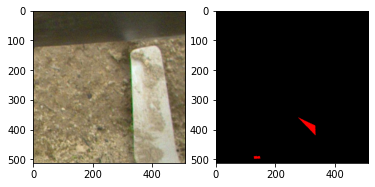

[0. 1. 2.]


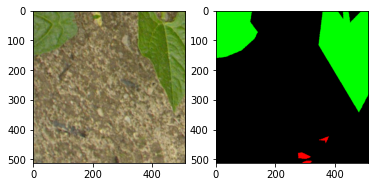

In [11]:
for k in range(2):
  # plot
  fig, ax = plt.subplots(1, 2)

  augmented_img, target = next(iterator)
  augmented_img = augmented_img[0]   # First element
  augmented_img = augmented_img * 255  # denormalize


  target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

  print(np.unique(target))

  target_img = np.zeros([target.shape[0], target.shape[1], 3])

  target_img[np.where(target == 0)] = [0, 0, 0]
  target_img[np.where(target == 1)] = [0, 255, 0] 
  target_img[np.where(target == 2)] = [255, 0, 0] 

  ax[0].imshow(np.uint8(augmented_img))
  ax[1].imshow(np.uint8(target_img))

  plt.show()

In [12]:
# Model

# input layer  

inputs = keras.layers.Input(shape = [target_h, target_w,3])


conv1 = keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = keras.layers.Dropout(0.1)(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = keras.layers.Dropout(0.1)(conv5)

up6 = keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
conv6 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = keras.layers.Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = keras.layers.Conv2D(num_classes, 1, activation = 'softmax')(conv9)

model = keras.models.Model(inputs = inputs, outputs = conv10)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [13]:
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(0,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# compole model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse', 
    metrics=[meanIoU] 
    )

In [14]:
from datetime import datetime

now = datetime.now().strftime('%b%d_%H-%M-%S')

checkpoint_dir = checkpoint_dir+str(now)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

# setup callbacks
# -----------------------

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'cp_{epoch:02d}.ckpt'), save_best_only=True, monitor='val_meanIoU'),
    tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=5)
]


In [15]:
history = model.fit(
          x=train_dataset,
          epochs=epochs,
          steps_per_epoch=len(train)/batch_size,
          validation_data=valid_dataset,
          validation_steps=len(valid)/batch_size,
          callbacks=callbacks
          )

564/564 [==============================] - ETA: 0s - loss: 0.1422 - meanIoU: 0.1225WARNING:tensorflow:From C:\Users\ricca\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: f:\Develop\scassorflow\homework-2\checkpointsDec07_19-49-47\cp_01.ckpt\assets
564/564 [==============================] - 237s 421ms/step - loss: 0.1422 - meanIoU: 0.1225 - val_loss: 0.1515 - val_meanIoU: 0.1314


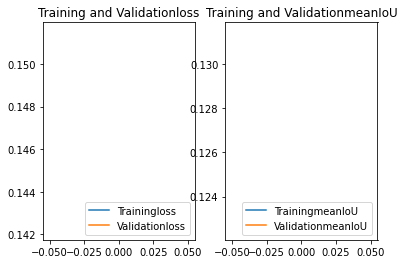

In [18]:
# plot alla metrics 
idx = 1
mtr = ['loss','meanIoU']
for m in mtr:
    x = history.history[m]
    val_x = history.history['val_' + m]

    plt.subplot(1, len(mtr), idx)
    plt.plot(x, label='Training ' + m)
    plt.plot(val_x, label='Validation ' + m)
    plt.legend(loc='lower right')
    plt.title('Training and Validation ' + m)
    idx += 1

plt.show()

In [97]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# return {rle crop prediction, rle weed prediction} img shape
def make_prediction(model, img_path, use_crop):
    image = Image.open(img_path)
    
    sub_images = cropImg(image, target_w, target_h) if use_crop else [image]

    # get how many images compose a line
    # this is important because later we have a 2d vector of cropped images that should be flattened
    # if we are able to track how many images make a original line we can flatten it and contat the next one
    # preserving the order of flattened pixel of the original image
    x_div = int(image.size[0] / target_w)    
    if x_div <= 0:
        x_div = 1

    #print("Original size: "+ str(image.size)+" divider: "+ str(x_div))

    predictions = None
    row = None

    rowPos = 0
    for img in sub_images:
        out_size = img.size
        img = img.resize([target_w, target_h])
        img = np.array(img) / 255.
        img = tf.expand_dims(img, 0)

        out = model(img, training=False) # predict     
        out = tf.math.argmax(out, axis=-1) # compress output in 2d tensor with 0,1,2 values for each pixel
        out= tf.squeeze(out, 0) # remove batch dimension an leav 2d      

        if rowPos == 0:
            row = out
        else:
            row = np.concatenate((row, out), axis=1)

        rowPos += 1
        # check if a row is complete
        if rowPos >= x_div : 
            if predictions is None:
                predictions = np.array(row).flatten()
            else:
                predictions = np.concatenate((predictions, np.array(row).flatten()))
            rowPos = 0
            #print(row.shape)

    # here we have the flattened resoult ready to be transformed into rle
    return {'crop': rle_encode(predictions == 1), 'weed':rle_encode(predictions == 2)}, out_size


# create function to evaluate the model and output results in requeisted format
def output_predictions(model, test_dir, use_crop):
    submission_dict = {}
    #print(test_dir)

    # iterate all datasets keeping name
    for team in os.listdir(test_dir): #team == dataset name
        team_dir = os.path.join(test_dir, team)

        # iterate all corps for a dataset keeping name
        for crop in os.listdir(team_dir):
            crop_dict = {}
            img_dir = os.path.join(team_dir, crop)
            img_dir = os.path.join(img_dir, "Images")
            # iterate all images 
            for fl in os.listdir(img_dir):
                #print("img: "+ fl)
                # get prediction from model
                prediction, shape = make_prediction(model, os.path.join(img_dir, fl), use_crop)

                filename, file_extension = os.path.splitext(fl)
                # prepare output dict
                submission_dict[filename] = {
                    'shape': shape,
                    'team': team,
                    'crop': crop,
                    'segmentation': prediction
                }
            # end for fl
        # end for crop
    #end for team

    return submission_dict
    


In [98]:
import json

# output last model
print("Making prediction with latest model...")
loss, metrics = model.evaluate(valid_dataset, verbose=2, steps=len(valid))

iou = "{:5.2f}".format(100 * metrics)
loss = "{:5.2f}".format(loss)

print("Last model expected results: loss:{}, iou: {}%".format(loss, iou))
res = output_predictions(model, test_dir, use_crop)

name = '0latest_iou' + iou + '_loss' + loss +'.json'
with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

print("Done")

Making prediction with latest model...
60/60 - 5s - loss: 0.1515 - meanIoU: 0.1314
Last model expected results: loss: 0.15, iou: 13.14%
f:\Develop\scassorflow\homework-2\test
img: Bipbip_haricot_im_00211.jpg
Original size: (2048, 1536) divider: 4
img: Bipbip_mais_im_01931.jpg
Original size: (2048, 1536) divider: 4
img: Pead_haricot_00130_i750.jpg
Original size: (3280, 2464) divider: 6
img: Pead_mais_00173_i900.jpg
Original size: (3280, 2464) divider: 6
img: Roseau_haricot_0010_false.png
Original size: (1227, 819) divider: 2
img: Roseau_mais_0008_false.png
Original size: (1226, 821) divider: 2
img: Weedelec_haricot_2019-09-25T114419-14.jpg
Original size: (5184, 3456) divider: 10
img: Weedelec_mais_2019-09-25T120608-14.jpg
Original size: (5184, 3456) divider: 10


In [ ]:
import json

# predict with checkpoint models
print("Making prediction with best models, this may take a while...")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num = 0
ckps = os.listdir(checkpoint_dir)
for cp in ckps:
    model.load_weights(os.path.join(checkpoint_dir, cp))

    loss, metrics = model.evaluate(valid_dataset, verbose=2, steps=len(valid))

    #acc = "{:5.2f}".format(100 * metrics)
    iou = "{:5.2f}".format(100 * metrics)
    loss = "{:5.2f}".format(loss)

    print("Model expected results: loss:{}, iou: {}%".format(loss, acc, iou))
    res = output_predictions(model, test_dir, use_crop)

    # write to file
   
    name = 'iou' + iou + '_loss' + loss +'.json'
    with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

    num += 1
    print("Progress: "str(num)+"/"+str(len(ckps)))

print("Done")